## Notebook 6 Supplementary A: Demonstration of how Gradient Boosting Method (GBM) works for Classification.

Created by Christopher Monterola

A step-by-step process demonstrating how GBM combines gradient descent with weak decision tree learners in building one of the winningest algorithm in machine learning.

In [30]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


# Illustration: Classification of Recovered individuals using COVID19 data.

Let's look at a simple data looking at *Recovery* of symptomatic COVID19 patients based on their *Age*, *Gender*, *Income*.     

Income level $A$ means belonging to household earnings of > Php 1 M annually;    
Income level $B$: Php 240 k to Php 1M;  
Income level $C$: < Php 240 k.    

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
data_dir = ''

In [33]:
df_weight = pd.read_excel(data_dir +'Covid19.xlsx', sheet_name="Sheet1")
dummy=df_weight
df_weight

,Age,Gender,Income,Recovered
0,64,Male,C,No
1,34,Female,B,Yes
2,65,Female,C,Yes
3,72,Female,B,No
4,62,Male,A,Yes
5,50,Male,A,Yes


Let's set the *Recovered* to be the target variable and the features as *Age*, *Gender* and *Income*.

In [34]:
df_features=dummy.drop('Recovered', axis=1)
len(df_features)
df_features.head()

,Age,Gender,Income
0,64,Male,C
1,34,Female,B
2,65,Female,C
3,72,Female,B
4,62,Male,A


Encode *Gender* to be 1 for *Male* and 0 for *Female*.

In [35]:
Gender_mapping = {
'Male': 1,
'Female': 0}
df_features['Gender'] = df_features['Gender'].map(Gender_mapping)
df_features

,Age,Gender,Income
0,64,1,C
1,34,0,B
2,65,0,C
3,72,0,B
4,62,1,A
5,50,1,A


In [36]:
Income_mapping = {
'A': 2,
'B': 1,
'C': 0}
df_features['Income'] = df_features['Income'].map(Income_mapping)
df_features

,Age,Gender,Income
0,64,1,0
1,34,0,1
2,65,0,0
3,72,0,1
4,62,1,2
5,50,1,2


In [37]:
df_features.columns

Index(['Age', 'Gender', 'Income'], dtype='object')

In [38]:
Recovered_mapping = {
'Yes': 1,
'No': 0}
dummy['Recovered'] = dummy['Recovered'].map(Recovered_mapping)
dummy['Recovered']

0    0
1    1
2    1
3    0
4    1
5    1
Name: Recovered, dtype: int64

# Step 1: Make the first approximation of predicted Recovery by minimizing the cost function C.

The Cost function $C$ is given by: $C = - \sum_i y_i \log (P(y_{pred_i})) + (1 - y_i) \log (1 - P(y_{pred_i}))$

Solving for $y_{pred_i}$ that will minimize $C$, we have  $y_{pred_i} = $ constant $ = \log (odds) = \log$ (Number of Yes/ Number of No) $= \log (4/2) = 0.69 $. Therefore, the first approximation of gradient method for the predicted recovered rate is just the $\log (odds)$ for all the cases, the corresponding value for average in classification. 


In [39]:
np.log(2)

0.6931471805599453

In [40]:
Prediction_0= 6*[np.log(4/2)]
Prediction_0

[0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453,
 0.6931471805599453]

In [41]:
dummy = dummy.assign(Prediction_0 = Prediction_0 )
dummy

,Age,Gender,Income,Recovered,Prediction_0
0,64,Male,C,0,0.693147
1,34,Female,B,1,0.693147
2,65,Female,C,1,0.693147
3,72,Female,B,0,0.693147
4,62,Male,A,1,0.693147
5,50,Male,A,1,0.693147


Calculate the residual by calculating the gradient $\Delta_i$ (hence, the Gradient term in the G of GBM) with respect to the predicted value : $\Delta_i= y_i - \frac{1}{1 + \exp (-\log (odds))} = Observed/Recovered - \frac{1}{1 + \exp (-\log (odds))}$    

$\Delta_i = Observed/Recovered - \frac{\exp (\log (odds))}{1 + \exp (\log (odds))} = Observed/Recovered - Q(\log(odds))$ 

where $Q (x)  = \frac{1}{1 + \exp (-x))}$.

In [42]:
dummy['Recovered']

0    0
1    1
2    1
3    0
4    1
5    1
Name: Recovered, dtype: int64

In [43]:
Residual = dummy['Recovered'] - ((np.exp(Prediction_0)) / (1.0 + np.exp(Prediction_0)))
Residual

0   -0.666667
1    0.333333
2    0.333333
3   -0.666667
4    0.333333
5    0.333333
Name: Recovered, dtype: float64

In [44]:
dummy = dummy.assign(Residual1 = Residual)
dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1
0,64,Male,C,0,0.693147,-0.666667
1,34,Female,B,1,0.693147,0.333333
2,65,Female,C,1,0.693147,0.333333
3,72,Female,B,0,0.693147,-0.666667
4,62,Male,A,1,0.693147,0.333333
5,50,Male,A,1,0.693147,0.333333


# Step 2: Use decision tree in predicting the *pseudo-residual* of the predicted weight.

In [45]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(max_depth=2, random_state=0)
dec_tree.fit(df_features, dummy['Residual1'])

DecisionTreeRegressor(max_depth=2, random_state=0)

In [46]:
from sklearn.tree import export_graphviz

export_graphviz(dec_tree, out_file="mytree.dot", feature_names=df_features.columns, filled='true')

In [47]:
# !pip install graphviz

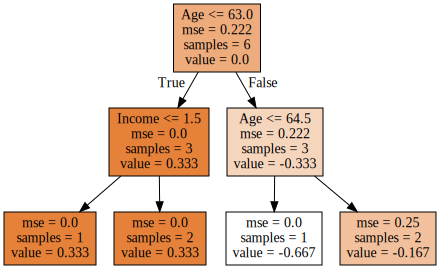

In [48]:
import graphviz
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The computation of the pseudo_residual due to decision tree is more involved and i would like to refer you to the derivation here for those who are interested here: https://www.youtube.com/watch?v=StWY5QWMXCw&t=72s

It will involve second partial derivatives, Taylor's expansion and a lot of algebraic simplifications but it will result to an elegantly beautiful expression given by:

Pseudo_Residual$_i$ $= \frac{\sum_i Residual_i}{\sum_i Q(Predict_i) (1- Q(Predict_i))} = \frac{\sum_i Residual_i}{\sum_i R(Predict_i)}$ 

where $R = Q (1-Q)$. 

To calculate the pseudo-residuals we need the elements of each of leaves, for quick reference see the figure below:


![GBM_decisiontree1](https://user-images.githubusercontent.com/25600601/129480420-7755efca-d4aa-4703-837a-22c6c8d2617b.png)

**Sample Calculations **

for Samples 0, 2 (*ie* i = 0,2): Pseudo_Residual$_i$ $= \frac{-0.67 + 0.33}{R(\log (4/2)) + R(\log (4/2))} = -0.77$

for Samples 1, 4, 5 (*ie* i = 1,4,5): Pseudo_Residual$_i$ $= \frac{0.33 + 0.33 + 0.33}{R(\log (4/2)) + R(\log (4/2)) + R(\log (4/2))} = 1.49$

for Sample 3 (*ie* i = 3): Pseudo_Residual$_i$ $= \frac{-.67}{R(\log (4/2))} = -3.02$

In [49]:
def R(p):
    Result = (((np.exp(p))) / (1.0 + np.exp(p)))*(1-(np.exp(p)) / (1.0 + np.exp(p)))
    return Result

#Sample 0, 2
print((-.67+.33)/(2*R(np.log(4/2))))

#Sample 1, 4, 5
print((.33 +.33 + .33)/(3*R(np.log(4/2))))

#Sample 3
print((-0.67)/(R(np.log(4/2))))

-0.765
1.4849999999999999
-3.015


In [50]:
dummy = dummy.assign(Pseudo_Residual1 = [-.77,1.49,-.77,-3.02,1.49,1.49])
dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1
0,64,Male,C,0,0.693147,-0.666667,-0.77
1,34,Female,B,1,0.693147,0.333333,1.49
2,65,Female,C,1,0.693147,0.333333,-0.77
3,72,Female,B,0,0.693147,-0.666667,-3.02
4,62,Male,A,1,0.693147,0.333333,1.49
5,50,Male,A,1,0.693147,0.333333,1.49


# Step 3: Use the *pseudo-residual* to update the predicted weight.

$y_{pred_i}^t = y_{pred_i}^{t-1} +$ (Learning_Rate * Pseudo_Residual1_i). Let's assume the *Learning_Rate* = 0.5. 

In [51]:
dummy = dummy.assign(Prediction_1 = dummy['Prediction_0'] + 0.5*dummy['Pseudo_Residual1'])

dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1,Prediction_1
0,64,Male,C,0,0.693147,-0.666667,-0.77,0.308147
1,34,Female,B,1,0.693147,0.333333,1.49,1.438147
2,65,Female,C,1,0.693147,0.333333,-0.77,0.308147
3,72,Female,B,0,0.693147,-0.666667,-3.02,-0.816853
4,62,Male,A,1,0.693147,0.333333,1.49,1.438147
5,50,Male,A,1,0.693147,0.333333,1.49,1.438147


# Step 4: Repeat Steps 1-3

In [52]:
#Back to Step 1

Residual = dummy['Recovered'] - ((np.exp(dummy['Prediction_1'])) / (1.0 + np.exp(dummy['Prediction_1'])))
dummy = dummy.assign(Residual2 = Residual) #Gradient descent

dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1,Prediction_1,Residual2
0,64,Male,C,0,0.693147,-0.666667,-0.77,0.308147,-0.576433
1,34,Female,B,1,0.693147,0.333333,1.49,1.438147,0.191832
2,65,Female,C,1,0.693147,0.333333,-0.77,0.308147,0.423567
3,72,Female,B,0,0.693147,-0.666667,-3.02,-0.816853,-0.306432
4,62,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832
5,50,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832


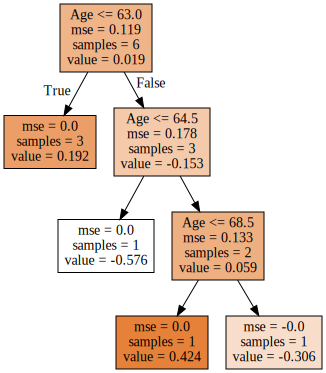

In [53]:
#Back to Step 2

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

dec_tree = DecisionTreeRegressor(max_depth=3, random_state=0)
dec_tree.fit(df_features, dummy['Residual2'])
export_graphviz(dec_tree, out_file="mytree.dot", feature_names=df_features.columns, filled=True)

import graphviz
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


Again, for quick reference see the figure below:

![GBM_decisiontree2](https://user-images.githubusercontent.com/25600601/129480463-7c686425-38ac-4fa4-8bdc-3bfb466d17d3.png)

In [54]:

def R(p):
    Result = (((np.exp(p))) / (1.0 + np.exp(p)))*(1-(np.exp(p)) / (1.0 + np.exp(p)))
    return Result

#Sample 0
print((-.58)/(R(.31)))

#Sample 1, 4, 5
print((.19 +.19 + .19)/(3*R(1.44)))

#Sample 2
print((.42)/(R(.31)))

#Sample 3
print((-.31)/(R(-.81)))

-2.3761858008067507
1.226948479378948
1.720686269549716
-1.454757476398818


In [55]:
dummy = dummy.assign(Pseudo_Residual2 = [-2.38,1.23,1.72,-1.45,1.22,1.22])
dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1,Prediction_1,Residual2,Pseudo_Residual2
0,64,Male,C,0,0.693147,-0.666667,-0.77,0.308147,-0.576433,-2.38
1,34,Female,B,1,0.693147,0.333333,1.49,1.438147,0.191832,1.23
2,65,Female,C,1,0.693147,0.333333,-0.77,0.308147,0.423567,1.72
3,72,Female,B,0,0.693147,-0.666667,-3.02,-0.816853,-0.306432,-1.45
4,62,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22
5,50,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22


In [56]:
#Back to Step 3

dummy = dummy.assign(Prediction_2 = dummy['Prediction_1'] + 0.5*dummy['Pseudo_Residual2'])
dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1,Prediction_1,Residual2,Pseudo_Residual2,Prediction_2
0,64,Male,C,0,0.693147,-0.666667,-0.77,0.308147,-0.576433,-2.38,-0.881853
1,34,Female,B,1,0.693147,0.333333,1.49,1.438147,0.191832,1.23,2.053147
2,65,Female,C,1,0.693147,0.333333,-0.77,0.308147,0.423567,1.72,1.168147
3,72,Female,B,0,0.693147,-0.666667,-3.02,-0.816853,-0.306432,-1.45,-1.541853
4,62,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22,2.048147
5,50,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22,2.048147


In [57]:
#Back to Step 1

Residual = dummy['Recovered'] - ((np.exp(dummy['Prediction_2'])) / (1.0 + np.exp(dummy['Prediction_2'])))
dummy = dummy.assign(Residual3 = Residual) #Gradient descent

dummy

,Age,Gender,Income,Recovered,Prediction_0,Residual1,Pseudo_Residual1,Prediction_1,Residual2,Pseudo_Residual2,Prediction_2,Residual3
0,64,Male,C,0,0.693147,-0.666667,-0.77,0.308147,-0.576433,-2.38,-0.881853,-0.292794
1,34,Female,B,1,0.693147,0.333333,1.49,1.438147,0.191832,1.23,2.053147,0.113735
2,65,Female,C,1,0.693147,0.333333,-0.77,0.308147,0.423567,1.72,1.168147,0.237190
3,72,Female,B,0,0.693147,-0.666667,-3.02,-0.816853,-0.306432,-1.45,-1.541853,-0.176266
4,62,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22,2.048147,0.114240
5,50,Male,A,1,0.693147,0.333333,1.49,1.438147,0.191832,1.22,2.048147,0.114240


Let's look at the residuals (gradient) and note that it decreases every iteration.

In [58]:
ssq1 = np.sum(dummy['Residual1']**2) # Sum of squares of residuals
ssq2 = np.sum(dummy['Residual2']**2)
ssq3 = np.sum(dummy['Residual3']**2)

print(round(ssq1,2))
print(round(ssq2,2))
print(round(ssq3,2))


1.33
0.72
0.21


### Conclusion

We have demonstrated here how the GBM works for a classification. Again, below is a visual representation of how the error decreases as a function of iteration parametrized as *n_estimator* in GBM.

![algorithm-iterations width="50000px"](https://user-images.githubusercontent.com/25600601/112873342-185b7900-90f4-11eb-8292-a3aa8a5a2a9e.png)

